In [3]:
import Parity_Data_Generator
import InputToParityESN
# import ParityToOutputESN
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import time

rng = np.random.RandomState(42)

In [4]:
N = 20000   # number of datapoints
n = 3       # n-parity

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 8.484100341796875 seconds ---


In [5]:
def runSomeConfigs(spectral_rad, leak_r,num_neurons=500):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=num_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # from 0.9 the test error is 0.0
                          leak_rate= leak_r,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_bits, train_parity)
    pred_test = nParityESN.predict(test_bits)

    #### Rounding
    better_pred_test = []           # Maybe don't round and return "true" results from pred_test
    for x in pred_test:
        better_pred_test.append(0 if x < 0.5 else 1)
    predictedParity = np.array(better_pred_test).reshape(-1,1)

    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
    print(test_error)
    return test_error

In [6]:
# num_neurons = [500, 600, 700, 800, 900, 1000]
num_neurons = [500]
l_rate = np.linspace(0.01, 0.2, num=20)
sp_rad = np.linspace(0.7, 1.0, num=4)

run_time = time.time()
iterations, iterationcount = len(num_neurons)*len(sp_rad)*len(l_rate), 0
errors = np.zeros((len(l_rate),len(sp_rad)))

for n in num_neurons:
    for i,l in enumerate(l_rate):
        for j,s in enumerate(sp_rad):
            print("Neurons:", n, "Spectral-radius:", s, "Leak-rate:", l)
            errors[i][j] = runSomeConfigs(s,l,n)
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))

print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 500 Spectral-radius: 0.7 Leak-rate: 0.01
harvesting states...
fitting...
training error:
0.421061833976
Testing error
0.655542608158
--- Progress: 1.25% --- 0.5650989731152852 minutes ---
Neurons: 500 Spectral-radius: 0.8 Leak-rate: 0.01
harvesting states...
fitting...
training error:
0.416591743483
Testing error
0.611509970846
--- Progress: 2.50% --- 1.1157656033833823 minutes ---
Neurons: 500 Spectral-radius: 0.9 Leak-rate: 0.01
harvesting states...
fitting...
training error:
0.411586665411
Testing error
0.598551492262
--- Progress: 3.75% --- 1.668669585386912 minutes ---
Neurons: 500 Spectral-radius: 1.0 Leak-rate: 0.01
harvesting states...
fitting...
training error:
0.411032497654
Testing error
0.606217782649
--- Progress: 5.00% --- 2.2274563193321226 minutes ---
Neurons: 500 Spectral-radius: 0.7 Leak-rate: 0.02
harvesting states...
fitting...
training error:
0.345639743458
Testing error
0.535697883347
--- Progress: 6.25% --- 2.782797094186147 minutes ---
Neurons: 500 Spec

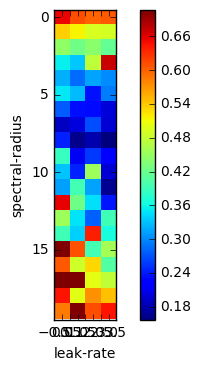

In [7]:

plt.imshow(errors, interpolation="nearest", origin="upper")
plt.xlabel("leak-rate")
plt.ylabel("spectral-radius")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


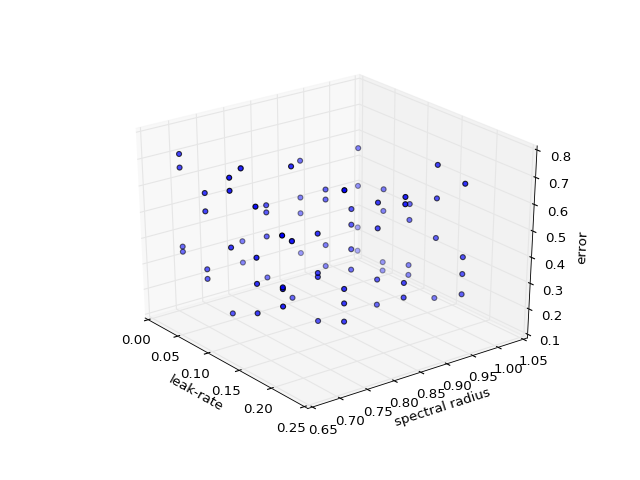

In [54]:
%matplotlib notebook
# import plotly.plotly as py
# import plotly.graph_objs as go
# py.sign_in('HansBambel', 'T0F76G8esWCDFNmIVEUv')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = []
y = []
z = errors.reshape(-1)

for i in sp_rad:
    x.extend(l_rate)
for i in l_rate:
    y.extend(sp_rad)

# print(x)
# print(y)
# print(z.reshape(-1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('leak-rate')
ax.set_ylabel('spectral radius')
ax.set_zlabel('error')

plt.show()

print("### Input-->Parity ###")
run_time = time.time()
# get good configs for a slow ESN
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=500,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.95,  # from 0.9 the test error is 0.0
                          leak_rate= 0.5,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
# print(np.shape(bits),np.shape(parity),np.shape(target))
nParityESN.fit(train_bits, train_parity)
pred_test = nParityESN.predict(test_bits)

#### Rounding
better_pred_test = []           # Maybe don't round and return "true" results from pred_test
for x in pred_test:
    better_pred_test.append(0 if x < 0.5 else 1)
predictedParity = np.array(better_pred_test).reshape(-1,1)

print("Testing error")
print(np.sqrt(np.mean((predictedParity - test_parity) ** 2)))

print("--- %s seconds ---" % (time.time() - run_time))
print("--- %s minutes ---" % (((time.time() - run_time)/60)))